# 1. Import packages

In [1]:
import os
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import logging 

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [72]:
logger.info("dd")

INFO: dd


# 2. Data loading

## 2.1. Dataset description

### A toy dataset for now
#### G-10 currency pairs. Every curreny other than USD is against USD. So we have 9 pairs in total
- gbpusd, usdsek, usdnok, usdjpy, usdcad, usdchf, nzdusd, eurusd, audusd

#### Period in use: May 2019 (1 month)

## 2.2 Loading a toy data set

In [74]:
toy_path = '../dataset/'
toy_folders = ['toyset']

# csv files have no explicit column header, but column names come in this order.
# 'timestamp',  'opening', 'high', 'low', 'close', 'volume'
# As we are only interested in timestamp and close prices, we set `usecols` = [0,4], a list of indices
col_names = ['datetime',  'opening', 'high', 'low', 'close', 'volume']
usecols = [0, 2, 3]

df = {}
f = pd.DataFrame(columns=col_names)
total_size = 0
logger.info("Loading...")
for folder in toy_folders:
    files = os.listdir(toy_path+folder)
    for file in files:
        if file.endswith("05.csv"):
            logger.info(file)
            tmp = pd.read_csv(os.path.join(toy_path, folder, file),
                              delimiter=';', header=0, names=col_names, usecols=usecols)
            loaded_ccy = file[:6]
            if loaded_ccy in df.keys():
                df[loaded_ccy] = df[loaded_ccy].append(tmp, ignore_index=True)
            else:
                df[loaded_ccy] = tmp.copy()
            total_size += len(df[loaded_ccy])
logger.info("Complted.")

INFO: Loading...
INFO: nzdusd_DAT_ASCII_NZDUSD_M1_201905.csv
INFO: usdchf_DAT_ASCII_USDCHF_M1_201905.csv
INFO: usdnok_DAT_ASCII_USDNOK_M1_201905.csv
INFO: gbpusd_DAT_ASCII_GBPUSD_M1_201905.csv
INFO: usdsek_DAT_ASCII_USDSEK_M1_201905.csv
INFO: usdjpy_DAT_ASCII_USDJPY_M1_201905.csv
INFO: eurusd_DAT_ASCII_EURUSD_M1_201905.csv
INFO: usdcad_DAT_ASCII_USDCAD_M1_201905.csv
INFO: audusd_DAT_ASCII_AUDUSD_M1_201905.csv
INFO: Complted.


In [4]:
print('We have {:d} data points in total for all pairs'.format(total_size))

We have 287995 data points in total for all pairs


In [5]:
df.keys()

dict_keys(['nzdusd', 'usdchf', 'usdnok', 'gbpusd', 'usdsek', 'usdjpy', 'eurusd', 'usdcad', 'audusd'])

In [6]:
ccy_list = list(df.keys())
print('We have a list of currency pairs:', ccy_list)

We have a list of currency pairs: ['nzdusd', 'usdchf', 'usdnok', 'gbpusd', 'usdsek', 'usdjpy', 'eurusd', 'usdcad', 'audusd']


In [7]:
print('e.g.', ccy_list[0])
df[ccy_list[0]].head()

e.g. nzdusd


,datetime,high,low
0,20190501 000100,0.66490,0.66488
1,20190501 000200,0.66490,0.66485
2,20190501 000300,0.66491,0.66489
3,20190501 000400,0.66490,0.66489
4,20190501 000500,0.66490,0.66488


#### We do not have ask prices in our data set.
- We take high prices as `ask_price` and low prices as `bid_price` for now just until we have a new data set.

In [8]:
df['eurusd'].columns

Index(['datetime', 'high', 'low'], dtype='object')

In [9]:
for ccy in ccy_list:
    df[ccy].rename(columns={'high': 'ask_price', 'low': 'bid_price'}, inplace=True)

## 2.3 Data Integrity Check

In [10]:
for i, ccy in enumerate(ccy_list):
    desc = df[ccy].describe()
    desc.rename(columns={'ask_price': ccy+'_ask', 'bid_price':ccy+'_bid'}, inplace=True)
    if i == 0:
        df_desc = desc.copy()
    else:
        df_desc = pd.merge(df_desc, desc, left_index=True, right_index=True)

- Outliers: none.
- Index: The number of data points a little vary. See the **2.5 `timestamp` policy** to handle this.

In [11]:
df_desc

,nzdusd_ask,nzdusd_bid,usdchf_ask,usdchf_bid,usdnok_ask,usdnok_bid,gbpusd_ask,gbpusd_bid,usdsek_ask,usdsek_bid,usdjpy_ask,usdjpy_bid,eurusd_ask,eurusd_bid,usdcad_ask,usdcad_bid,audusd_ask,audusd_bid
count,31885.000000,31885.000000,31871.000000,31871.000000,32383.000000,32383.000000,31953.000000,31953.000000,31616.000000,31616.000000,32473.000000,32473.000000,31968.000000,31968.000000,31900.000000,31900.000000,31946.000000,31946.000000
mean,0.656137,0.656059,1.011103,1.011012,8.740825,8.739539,1.285139,1.284985,9.596976,9.595584,110.015410,110.003956,1.118613,1.118509,1.345870,1.345737,0.694530,0.694438
std,0.004287,0.004279,0.005351,0.005350,0.034109,0.034058,0.017836,0.017832,0.043117,0.043147,0.684108,0.685476,0.002978,0.002973,0.003246,0.003238,0.004925,0.004917
min,0.648210,0.648130,1.000250,1.000060,8.609150,8.607350,1.256290,1.255900,9.469900,9.468420,108.285000,108.277000,1.111240,1.110700,1.336170,1.335710,0.686470,0.686440
25%,0.652390,0.652320,1.007450,1.007330,8.719160,8.718090,1.267360,1.267200,9.566308,9.564930,109.551000,109.540000,1.116350,1.116270,1.343670,1.343560,0.691100,0.691010
50%,0.655690,0.655590,1.009590,1.009510,8.748570,8.747320,1.284000,1.283810,9.600090,9.598530,109.815000,109.796000,1.118780,1.118630,1.346150,1.346040,0.692870,0.692800
75%,0.659480,0.659390,1.016550,1.016420,8.764320,8.762980,1.302110,1.301910,9.634173,9.632803,110.348000,110.336000,1.120640,1.120550,1.347600,1.347480,0.699320,0.699230
max,0.666510,0.666420,1.022590,1.022250,8.804460,8.803100,1.317620,1.317360,9.687630,9.686170,111.699000,111.657000,1.126470,1.126210,1.356440,1.356270,0.706070,0.705980


In [12]:
max_datapoints = np.max(df_desc.loc['count'])
max_datapoints

32473.0

## 2.4 Drop from and add some columns to `df`

- Drop: `datetime` (no use)
- Add: `ccy`, `timestamp`
- Retain: `bid_price`, `ask_price`

In [13]:
for ccy in ccy_list:
    df[ccy]['ccy'] = ccy
    df[ccy]['timestamp'] = df[ccy].datetime.apply(lambda x: pd.to_datetime(x))
    cols_to_use = ['timestamp', 'ccy', 'bid_price', 'ask_price']
    df[ccy] = df[ccy][cols_to_use]

In [14]:
#rand_ccy = ccy_list[np.random.randint(len(ccy_list))]
rand_ccy='usdjpy'
df[rand_ccy].sample(5)

,timestamp,ccy,bid_price,ask_price
28271,2019-05-28 18:55:00,usdjpy,109.352,109.364
27639,2019-05-28 08:21:00,usdjpy,109.463,109.473
8588,2019-05-08 23:30:00,usdjpy,109.908,109.917
24913,2019-05-24 07:52:00,usdjpy,109.614,109.625
30026,2019-05-30 00:10:00,usdjpy,109.599,109.603


### Check if we have all data points in `df`

In [15]:
assert np.sum([len(df[ccy]) for ccy in ccy_list]) == total_size, "We got some data loss."

## 2.5 Padding missing time to `df`

### Creating a new index `idx`
#### `timestamp` policy:
- If any curency pair has any price at timestamp $t$, then we have the timestamp $t$ for the rest of the currency pairs as well.

#### We create a union set `idx` of `timestamp` for every currency pair so that we can cover every data point.

In [16]:
ccy_idx = {}
for i, ccy in enumerate(ccy_list):
    ccy_idx[ccy] = pd.Index(df[ccy].timestamp)
    if i == 0 :
        idx = pd.Index(ccy_idx[ccy])
    else:
        idx = idx.union(ccy_idx[ccy])

#### Apply `idx` to every `df[ccy]`

In [17]:
for ccy in ccy_list:
    df_ccy = pd.DataFrame(index=idx)
    df[ccy] = df_ccy.merge(df[ccy], how='left', on='timestamp')
    df[ccy]['ccy'].fillna(ccy, inplace=True)

In [18]:
assert np.min([df[f].shape[0] for f in df.keys()]) >= max_datapoints, "We got some data loss."

#### We get the global earliest date and last date over the entire data set.

## 2.6 Create the data set `X`
### We do it simply by appending `df` for each currency pair to create the data set `X`

Create a template for `X`

In [19]:
X = pd.DataFrame(columns = df[ccy_list[0]].columns)
X

,timestamp,ccy,bid_price,ask_price


In [20]:
for ccy in ccy_list:
    X = X.append(df[ccy], ignore_index=False, sort=False)

In [21]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price
5481,2019-05-06 19:22:00,usdcad,1.34493,1.34497
14195,2019-05-14 20:36:00,audusd,0.69269,0.69271
23193,2019-05-23 02:34:00,usdchf,1.00868,1.00889
14872,2019-05-15 07:53:00,nzdusd,0.65527,0.65536
13242,2019-05-14 04:43:00,eurusd,1.12390,1.12396


## 2.7 Missing Data Analysis
#### An imputing policy:
- First we sort `X` by `ccy` and `timestamp`, and reset the index.
- Then we group `X` by `ccy`
- We finally forwardfill (use previous values to fill missing values)

In [22]:
X = X.sort_values(by=['ccy','timestamp'])
X.reset_index(drop=True, inplace=True)

### Missing data
- `bid_price`: 4,676
- `ask_price`: 4,676
- We impute them by previous values (done by group)

In [23]:
X.isna().sum()

timestamp       0
ccy             0
bid_price    4676
ask_price    4676
dtype: int64

In [24]:
g = X.groupby('ccy')
X['bid_price'] = g['bid_price'].fillna(method='ffill')
X['ask_price'] = g['ask_price'].fillna(method='ffill')

#### Now we have no missing value. Cleaning is *done*.

In [25]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
dtype: int64

## 2.8 Calculate `bid_ret`, `ask_ret` and `mid_price`

In [26]:
X.loc[X['ccy'] == X['ccy'].shift(), 'bid_ret'] = np.log(X['bid_price']) - np.log(X['bid_price'].shift())
X.loc[X['ccy'] == X['ccy'].shift(), 'ask_ret'] = np.log(X['ask_price']) - np.log(X['ask_price'].shift())
X['mid_price'] = X['ask_price'] - X['bid_price']

In [27]:
X_boundary = X.loc[X['ccy'] != X['ccy'].shift()]
X_boundary

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-05-01 00:01:00,audusd,0.70514,0.70517,NaN,NaN,0.00003
32519,2019-05-01 00:01:00,eurusd,1.12182,1.12188,NaN,NaN,0.00006
65038,2019-05-01 00:01:00,gbpusd,1.30426,1.30430,NaN,NaN,0.00004
97557,2019-05-01 00:01:00,nzdusd,0.66488,0.66490,NaN,NaN,0.00002
130076,2019-05-01 00:01:00,usdcad,1.33774,1.33776,NaN,NaN,0.00002
162595,2019-05-01 00:01:00,usdchf,1.01927,1.01930,NaN,NaN,0.00003
195114,2019-05-01 00:01:00,usdjpy,111.48800,111.48900,NaN,NaN,0.00100
227633,2019-05-01 00:01:00,usdnok,8.62020,8.62055,NaN,NaN,0.00035
260152,2019-05-01 00:01:00,usdsek,9.48740,9.48757,NaN,NaN,0.00017


In [28]:
X.dropna(axis='index', how='any', inplace=True)

In [29]:
X.isna().sum()

timestamp    0
ccy          0
bid_price    0
ask_price    0
bid_ret      0
ask_ret      0
mid_price    0
dtype: int64

In [30]:
X.reset_index(drop=True, inplace=True)

In [31]:
X.head()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
0,2019-05-01 00:02:00,audusd,0.70514,0.70517,0.000000,0.000000,0.00003
1,2019-05-01 00:03:00,audusd,0.70517,0.70517,0.000043,0.000000,0.00000
2,2019-05-01 00:04:00,audusd,0.70517,0.70518,0.000000,0.000014,0.00001
3,2019-05-01 00:05:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001
4,2019-05-01 00:06:00,audusd,0.70517,0.70518,0.000000,0.000000,0.00001


## 2.9 Let's plot for a visual check.

In [32]:
# Code: https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
def plot_multi(data, cols=None, spacing=.1, **kwargs):

    from pandas import plotting

    # Get default color style from pandas - can be changed to any other color list
    if cols is None: cols = data.columns
    if len(cols) == 0: return
    colors = getattr(getattr(plotting, '_matplotlib').style, '_get_standard_colors')(num_colors=len(cols))

    # First axis
    ax = data.loc[:, cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    ax.tick_params(axis='y', colors=colors[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data.loc[:, cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])
        ax_new.tick_params(axis='y', colors=colors[n % len(colors)])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label

    ax.legend(lines, labels, loc=0)
    return ax

In [33]:
bid_dict = dict()
ask_dict = dict()
for ccy in ccy_list:
    bid_dict[ccy] = X[X.ccy==ccy].bid_price.reset_index(drop=True)
    ask_dict[ccy] = X[X.ccy==ccy].ask_price.reset_index(drop=True)
X_bid = pd.DataFrame(bid_dict)
X_ask = pd.DataFrame(ask_dict)

In [34]:
X_bid.head()

,nzdusd,usdchf,usdnok,gbpusd,usdsek,usdjpy,eurusd,usdcad,audusd
0,0.66485,1.01928,8.62052,1.30425,9.48757,111.488,1.12182,1.33776,0.70514
1,0.66489,1.01928,8.62105,1.30435,9.48757,111.488,1.12182,1.33777,0.70517
2,0.66489,1.01928,8.62104,1.30426,9.48757,111.489,1.12182,1.33781,0.70517
3,0.66488,1.01927,8.62111,1.30427,9.48757,111.487,1.12179,1.33783,0.70517
4,0.66488,1.01928,8.62132,1.30427,9.48790,111.488,1.12180,1.33784,0.70517


In [35]:
X_ask.head()

,nzdusd,usdchf,usdnok,gbpusd,usdsek,usdjpy,eurusd,usdcad,audusd
0,0.66490,1.01928,8.62105,1.30439,9.48757,111.489,1.12184,1.33780,0.70517
1,0.66491,1.01928,8.62106,1.30439,9.48757,111.489,1.12183,1.33781,0.70517
2,0.66490,1.01928,8.62124,1.30437,9.48757,111.489,1.12183,1.33784,0.70518
3,0.66490,1.01929,8.62135,1.30438,9.48791,111.489,1.12183,1.33788,0.70518
4,0.66489,1.01929,8.62141,1.30431,9.48791,111.488,1.12181,1.33787,0.70518


#### Bid prices

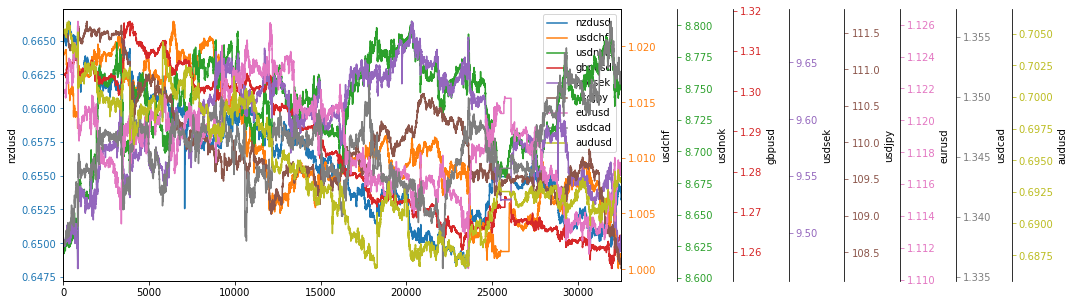

In [36]:
plot_multi(X_bid, figsize=(10, 5))

#### Ask prices

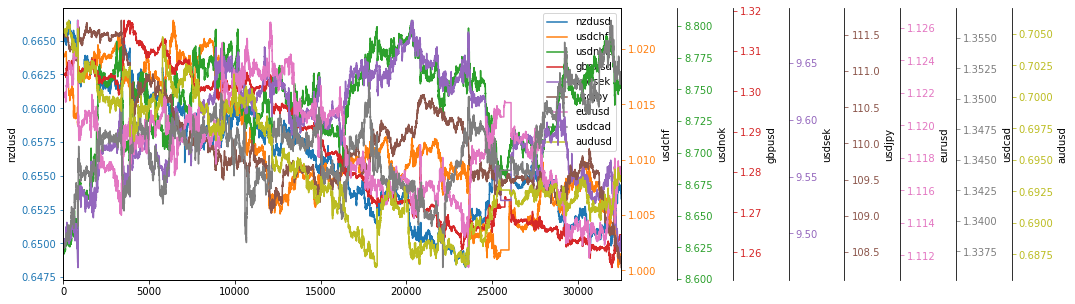

In [37]:
plot_multi(X_ask, figsize=(10, 5))

# 3. Data set `X` is ready

## 3.1 Take a look

In [38]:
X.shape

(292662, 7)

In [39]:
X.sample(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
3555,2019-05-03 11:17:00,audusd,0.70207,0.70220,0.000014,0.000014,0.00013
261307,2019-05-01 19:25:00,usdsek,9.53442,9.53491,-0.000041,0.000000,0.00049
23283,2019-05-23 04:05:00,audusd,0.68713,0.68724,0.000058,0.000116,0.00011
153696,2019-05-23 09:46:00,usdcad,1.34973,1.35012,-0.000126,-0.000037,0.00039
48689,2019-05-16 05:33:00,eurusd,1.12093,1.12114,0.000027,0.000161,0.00021


In [40]:
X[X.ccy=='gbpusd'].head(5)

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
65036,2019-05-01 00:02:00,gbpusd,1.30425,1.30439,-0.000008,0.000069,0.00014
65037,2019-05-01 00:03:00,gbpusd,1.30435,1.30439,0.000077,0.000000,0.00004
65038,2019-05-01 00:04:00,gbpusd,1.30426,1.30437,-0.000069,-0.000015,0.00011
65039,2019-05-01 00:05:00,gbpusd,1.30427,1.30438,0.000008,0.000008,0.00011
65040,2019-05-01 00:06:00,gbpusd,1.30427,1.30431,0.000000,-0.000054,0.00004


## Split: Training set and Validation set(=evaluation set)
- Training set `X_train`: The first two and a half weeks (From May 1, 2019 to May 19, 2019)
- Validation set `X_val`: The following one week (From May 20, 2019 to May 26, 2019)
- Test set `X_test`: The rest of days (From May 27, 2019 to May 31, 2019)
  - In fact, we never create `X_test` until the very last moment.

In [41]:
X_train = X[(X.timestamp >= pd.datetime(2019, 5, 1)) &
            (X.timestamp < pd.datetime(2019, 5, 20))]
X_val = X[(X.timestamp >= pd.datetime(2019, 5, 20)) &
          (X.timestamp < pd.datetime(2019, 5, 27))]

In [42]:
X.drop(X[(X.timestamp >= pd.datetime(2019, 5, 27)) & (
    X.timestamp < pd.datetime(2019, 6, 1))].index, inplace=True)

In [43]:
X.tail()

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
285878,2019-05-26 23:55:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285879,2019-05-26 23:56:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285880,2019-05-26 23:57:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285881,2019-05-26 23:58:00,usdsek,9.52895,9.52895,0.0,0.0,0.0
285882,2019-05-26 23:59:00,usdsek,9.52895,9.52895,0.0,0.0,0.0


## 3.2 Save to csv files

In [61]:
X_train.to_csv('../dataset/toy_X_train.csv', index=False)
X_val.to_csv('../dataset/toy_X_val.csv', index=False)

### The end of preprocessing ------------------------------------------------

# Dat2019/DRL/run.py

#### Import required packages

In [51]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

# utils
import time

# TensorFlow
import tensorflow as tf
import tensorflow.keras.optimizers as kop
import tensorflow.keras.losses as kls
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

#### Import our packages

In [45]:
from features import draw_episode

#### Configuration
- *Json* format or something else will be used later, but for now...

In [53]:
config = {}
config['lag'] = 20
config['ep_size'] = 100
config['init_lr'] = 0.005
config['momentum'] = 0.9
config['num_of_eval_data'] = 30
config['target_currency'] = 'audusd'
config['epochs'] = 100
config['timespan'] = 1440   # one full day (1440 minutes)

tf.keras.backend.set_floatx('float64')

In [47]:
class Policy(Model):
    def __init__(self):
        super(Policy, self).__init__('mlp_policy')
        self.fc1 = Dense(units=256, activation='relu')
        self.fc2 = Dense(units=64, activation='relu')
        self.value = Dense(1, activation='tanh', name='value')
        
        self.saved_log_probs = []
        self.rewards = 0
#         self.actions = []
        
    def call(self, inputs):
        # `inputs` is a numpy array. We convert to Tensor.
        x = tf.convert_to_tensor(inputs)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.value(x)
        
        return x
    
#     def choose_action(self, obs):
#         # self.call() will be executed under the hool.
#         value = self.predict(obs)
        
#         return np.squeeze(value, axis=-1)

In [48]:
policy = Policy()

In [49]:
def train_eval():
    # We use an optimizer defined in Keras (kop)
    optimizer = kop.SGD(
        learning_rate=config['init_lr'], momentum=config['momentum'], name='SGD')

    # Machine limits for floating point types.
    eps = np.finfo(np.float64).eps.item()
    rewards_over_time = []

    num_of_eval_data = config['num_of_eval_data']
    path = './base/best_model_' + \
        config['target_currency'] + str(time.time()) + '.tf'

    for epoch in range(config['epochs']):
        for ep_idx in range(config['ep_size']):
            prev_action = 0
            # n is `n-th` episode
            # ep_size is a length of one episode.
            # in draw_episode(), X[n:n+ep_size+1] will be used.
            
            # For a lag of 20,
            # feature_span[0] := [20 target's log return(bid prices),
            #                     20 target's log return(ask prices),
            #                     8*20 others' log return(bid prices),
            #                     8*20 others' log return(ask prices)]
            #     at the oldest time stamp.
            # (feature_span[-1] has features at the latest)
            # Features are nomalized within draw_episode()
            target_bid, target_ask, feature_span = \
                draw_episode(X=X_train, cur=config['target_currency'],
                             n=ep_idx, ep_size=config['ep_size'],
                             lag=config['lag'])
            bid, ask, features = target_bid[config['lag']:] * 1e3, \
                            target_ask[config['lag']:]*1e3, \
                            feature_span
            
            # We loop through time stamps in order within an episode.
            for t in range(config['timespan']):
                observation = feature_span[t]
                
                # The neural networks returns an action-like value
                # `state` is a numpy array.
                action_by_nets = policy(observation)
                
                # An actual action to take should effectively cause a trade.
                # Therefore, we subtract `prev_action_by_nets`
                # from `action_by_nets` and take it as our `action`
                action = action_by_nets - prev_action
                print(action, action.shape)
                price = 0
                if action > 0:
                    price = ask[t]  # We buy
                elif action < 0:
                    price = bid[t]  # We sell
                
                # This is an immediate reward caused by taking an action
                reward = tf.math.add(-1*action*price)
                
                # Accumulated rewards
                policy.rewards += reward
                
                prev_action = action_by_nets
            
            # Now that we've completed one episode,
            # we optimize the neural nets.
            losses = policy.train_on_batch(-policy.rewards / config['timespan'])
#             with tf.GradientTape() as tape:
#                 loss = -policy.rewards / config['timespan']
#             grads = tape.gradient(loss, policy.trainable_variables)
#             optimizer.apply_gradient(zip(grads, model.trainable_variables))
            
            if ep_idx % 10 == 0:
                logger.info('Epoch:{} Episode:{}. The training loss is {}'.format(epoch, ep_idx, loss.item()))
            
            policy.rewards = 0

In [54]:
train_eval()

ValueError: Input 0 of layer dense is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: [360]

# environment.py

In [135]:
import numpy as np
import pandas as pd

In [136]:
class ForexEnv(object):
    '''
    Observation:
        self.timestamp
        self.state =   3 (the day of the week, hour, minute) +
                       3 (the previous position; {-1, 0, 1}) + 
                      20 (the 10-minute bid and ask prices of the target currency) +
                      80 (the 10-minute mid prices of the rest of 8 currency pairs)
                   = 106 (total)
        self.price_record: bid and ask prices of the target currency
        
    Actions:
        -1: short 100%
         0: take a neutral position (no action) and 0 reward. 
        +1: long 100%
        
    Starting State:
        random start within training set.
        i.e., we pick an arbitrary number and take it as index to start with.                 
    '''
    
    def __init__(self, cur='audusd', lag=10, min_history=1440, mode='train'):
        self.ccy = cur
        self.lag = lag
        self.min_history = min_history
        self.index = None
        self.state = None
        self.price_record = None
        self.X_train = X_train
        self.X_val = X.val
        self.trainframe = self.X_train.index.values.tolist()
        self.valframe = self.X_val.index.values.tolist()
        self.train = self.trainframe[:-self.min_history]
        self.val = self.valframe[:-self.min_history]
        self.mode = mode

# experiment.py

In [46]:
import numpy as np

import time

In [47]:
cur ='eurusd'
reward_path = './results/rewards/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'
agent_path = './results/agents/' + cur + time.strftime("%Y%m%d-%H%M%S") + '/'

if not os.path.exists(reward_path):
    os.makedirs(reward_path)
if not os.path.exists(agent_path):
    os.makedirs(agent_path)


In [131]:
X_train.iloc[10:15]

,timestamp,ccy,bid_price,ask_price,bid_ret,ask_ret,mid_price
10,2019-05-01 00:12:00,audusd,0.70519,0.70520,0.000014,-0.000028,0.00001
11,2019-05-01 00:13:00,audusd,0.70518,0.70520,-0.000014,0.000000,0.00002
12,2019-05-01 00:14:00,audusd,0.70518,0.70519,0.000000,-0.000014,0.00001
13,2019-05-01 00:15:00,audusd,0.70519,0.70519,0.000014,0.000000,0.00000
14,2019-05-01 00:16:00,audusd,0.70520,0.70521,0.000014,0.000028,0.00001


In [63]:
from features import draw_episode

In [115]:
target_bid, target_ask, features = draw_episode(
    X, cur='audusd', n=2, ep_size=5, lag=2)

In [116]:
target_bid

array([0.70519, 0.70518, 0.70518, 0.70519, 0.7052 ])

In [117]:
target_bid.shape

(5,)

In [118]:
target_ask

array([0.7052 , 0.7052 , 0.70519, 0.70519, 0.70521])

In [119]:
target_ask.shape

(5,)

In [129]:
features[0]

array([ 0.1184248 , -0.58560619, -0.5855962 , -0.5855962 ,  1.00355167,
        1.44612103,  0.87973326,  1.6410534 ,  0.86520712,  0.86520712,
       -0.62372478,  3.08713404,  1.57963245,  2.55379478, -2.10809715,
       -1.21750035, -0.28469299, -0.28469299,  0.1184248 ,  0.5893887 ,
        0.56097837,  0.1184248 , -0.64285448,  0.1184248 ,  0.86517342,
        1.61193328, -0.25264583,  0.1184248 ,  0.60548446,  1.0925489 ,
       -0.32686362, -0.32686362, -1.14849256, -0.745386  , -0.71883333,
       -0.71883333])

In [121]:
features.shape

(3, 36)

In [122]:
features[0]

array([ 0.1184248 , -0.58560619, -0.5855962 , -0.5855962 ,  1.00355167,
        1.44612103,  0.87973326,  1.6410534 ,  0.86520712,  0.86520712,
       -0.62372478,  3.08713404,  1.57963245,  2.55379478, -2.10809715,
       -1.21750035, -0.28469299, -0.28469299,  0.1184248 ,  0.5893887 ,
        0.56097837,  0.1184248 , -0.64285448,  0.1184248 ,  0.86517342,
        1.61193328, -0.25264583,  0.1184248 ,  0.60548446,  1.0925489 ,
       -0.32686362, -0.32686362, -1.14849256, -0.745386  , -0.71883333,
       -0.71883333])

In [123]:
features[0].shape

(36,)

In [124]:
len(features)

3

In [102]:
np.empty(len(features))

array([-1.28822975e-231,  2.00389893e+000,  2.78113689e-314,
        2.78114481e-314,  2.78114482e-314,  2.12199580e-314,
        0.00000000e+000,  3.95252517e-323,  2.12199579e-314,
        2.76946182e-314,  2.76946163e-314,  2.76946188e-314,
        2.77594478e-314,  2.79264360e-314,  2.79264366e-314,
        2.79264373e-314,  2.79264379e-314,  2.79264385e-314,
        2.79264392e-314,  2.79264398e-314,  2.79264404e-314,
        2.21885319e-314, -1.28822975e-231,  2.00389893e+000,
        2.34573531e-314,  2.21885273e-314,  2.34575557e-314,
        2.21885273e-314,  2.34573147e-314,  2.21885273e-314,
        2.33376200e-314,  2.21885319e-314,  2.34574979e-314,
        2.21885273e-314,  1.29074111e-231, -1.28822975e-231,
        5.92878775e-323,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
        0.00000000e+000,  2.12199579e-314,  2.12199579e-314,
        0.00000000e+000,

In [103]:
features.shape[1]

180

In [104]:
df['eurusd']

,datetime,high,low
0,20190501 000100,1.12188,1.12182
1,20190501 000200,1.12184,1.12182
2,20190501 000300,1.12183,1.12182
3,20190501 000400,1.12183,1.12182
4,20190501 000500,1.12183,1.12179
5,20190501 000600,1.12181,1.12180
6,20190501 000700,1.12180,1.12179
7,20190501 000800,1.12180,1.12179
8,20190501 000900,1.12180,1.12180
9,20190501 001000,1.12184,1.12182


In [84]:
np.min([df[key].shape[0] for key in df.keys()])

31616

In [85]:
features.shape

(80, 360)